A continuación llevaremos a cabo una implementación alternativa del algoritmo de Gillespie para comparar los resultados obtenidos con la otra. La documentación relativa a esta implementación se encuentra disponible en [aquí](http://be150.caltech.edu/2019/handouts/12_stochastic_simulation.html) y fue realizada por Michael Elowitz y Justin Bois.

In [1]:
import biocircuits
from numba import jit,njit,float64,int32
import numba 
import numpy as np
import bokeh.io
import bokeh.plotting
import matplotlib.pyplot as plt

In [2]:
@numba.njit
def simple_propensity(propensities, population, t, n1, n2, k1, k2, β1, β2, kp1, kp2, γr1, γr2, γp1, γp2):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    r1, r2, p1, p2 = population

    # Update propensities
    propensities[0] = β1*((p2**n1)/(k1**n1 + p2**n1))  
    propensities[1] = γr1*r1  # Degrade mRNA
    propensities[2] = β2/(1 + (p1/k2)**n2)  # Make protein
    propensities[3] = γr2*r2  # Degrade protein
    propensities[4] = kp1*r1
    propensities[5] = γp1*p1
    propensities[6] = kp2*r2
    propensities[7] = γp2*p2

In [3]:
population_0 = np.array([0, 0, 0, 0], dtype=int)
time_points = np.linspace(0, 800,200)
args = (3.5, 3.5, 4400, 8080, 216/125, 216/125, 50, 45, 1/5, 50/251, 1/45, 1/45)

In [4]:
simple_update = np.array(
    [
        [1, 0, 0, 0],  #Create r1
        [-1, 0, 0, 0],  # Degrade r1
        [0, 1, 0, 0], #Create r2
        [0, -1, 0, 0], #Degrade r2
        [0, 0, 1, 0],  # Create p1
        [0, 0, -1, 0], # Degrade p1
        [0, 0, 0, 1],  # Create p2
        [0, 0, 0, -1], #Degrade p2
    ],
    dtype=np.int,
)

In [5]:
samples = biocircuits.gillespie_ssa(
    simple_propensity,
    simple_update,
    population_0,
    time_points,
    size=2000,
    args=args,
    n_threads=4,
    progress_bar=False,
)

In [6]:
samples

array([[[    0,     0,     0,     0],
        [    0,     3,     0,   550],
        [    0,    10,     0,  1563],
        ...,
        [   11,     4, 12922,  8633],
        [   12,     4, 13822,  8707],
        [    8,     2, 14648,  8357]],

       [[    0,     0,     0,     0],
        [    0,     2,     0,   440],
        [    1,     5,     5,  1097],
        ...,
        [    6,     4,  9863,  4156],
        [    4,     4,  9670,  4381],
        [    3,     2,  9457,  4447]],

       [[    0,     0,     0,     0],
        [    0,     2,     0,   219],
        [    0,     7,     0,  1017],
        ...,
        [   11,     4, 11611,  5767],
        [   13,     2, 12884,  5838],
        [   11,     1, 14202,  5717]],

       ...,

       [[    0,     0,     0,     0],
        [    0,     6,     0,   567],
        [    0,     7,     0,  1743],
        ...,
        [    6,     2, 12931,  3561],
        [    5,     1, 12886,  3353],
        [    2,     2, 12498,  3261]],

       [[    0,

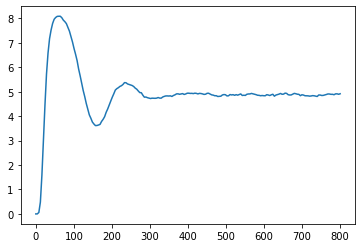

In [7]:
plt.plot(time_points,samples[:,:,0].mean(axis=0));

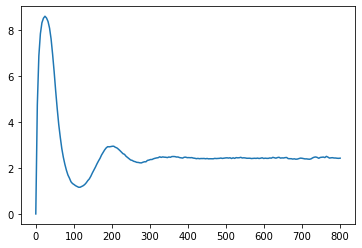

In [8]:
plt.plot(time_points,samples[:,:,1].mean(axis=0));

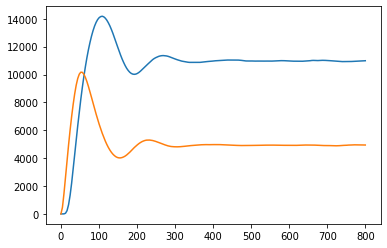

In [9]:
plt.plot(time_points,samples[:,:,2].mean(axis=0));
plt.plot(time_points,samples[:,:,3].mean(axis=0));

In [18]:
print('Valor esperado del ARNm 1:',samples[:, -100:, 0].mean())
print('Varianza del ARNm 1:',samples[:, -100:, 0].std()**2)
print('Ruido cuadrado del ARNm 1:', samples[:, -100:, 0].std()**2/samples[:, -100:, 0].mean()**2)

Valor esperado del ARNm 1: 4.879095
Varianza del ARNm 1: 7.011254480974999
Ruido cuadrado del ARNm 1: 0.29452162096580614


In [14]:
print('Valor esperado del ARNm 2:',samples[:, -100:, 1].mean())
print('Varianza del ARNm 2:', samples[:, -100:, 1].std()**2)
print('Ruido cuadrado del ARNm 2:',samples[:, -100:, 1].std()**2/samples[:, -100:, 1].mean()**2)

Valor esperado del ARNm 2: 2.43105
Varianza del ARNm 2: 3.4125183975
Ruido cuadrado del ARNm 2: 0.5774138796378273


In [15]:
print('Valor esperado de la proteína 1:',samples[:, -100:, 2].mean())
print('Varianza de la proteína 1:', samples[:, -100:, 2].std()**2)
print('Ruido cuadrado de la proteína 1:',samples[:, -100:, 2].std()**2/samples[:, -100:, 2].mean()**2)

Valor esperado de la proteína 1: 10989.3367
Varianza de la proteína 1: 3794404.88302811
Ruido cuadrado de la proteína 1: 0.03141960427346372


In [16]:
print('Valor esperado de la proteína 2:',samples[:, -100:, 3].mean())
print('Varianza de la proteína 2:', samples[:, -100:, 3].std()**2)
print('Ruido cuadrado de la proteína 2:',samples[:, -100:, 3].std()**2/samples[:, -100:, 3].mean()**2)

Valor esperado de la proteína 2: 4931.54507125
Varianza de la proteína 2: 1401012.2872635825
Ruido cuadrado de la proteína 2: 0.0576070891119697
